In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pdb
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import h5py

import time
import random
import string
from datetime import datetime

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import torch.optim as optim
import os

from src.configs import BallEncoder, BallDecoder, BallTransition
from src.e2c import E2C, compute_loss

### Method to create (3,32,32) tensor

In [3]:
def create_img(X, pos_bounds, radius=0.5, W=32):
    x, y, vx, vy = X

    # Check if center of ball outside image frame
    if x < pos_bounds[0] or x > pos_bounds[1]:
        return None
    elif y < pos_bounds[0] or y > pos_bounds[1]:
        return None

    x_px = int(round(W * x / posbounds[1]))
    y_px = int(round(W * y / posbounds[1]))
    r_px = int(round(radius / pos_bounds[1] * W))

    # Check if perimeter of ball outside image frame
    if x_px+r_px > W or x_px-r_px < 0:
        return None
    elif y_px+r_px > W or y_px-r_px < 0:
        return None

    img = np.ones((3,W,W))
    yy,xx = np.mgrid[:W, :W]
    circle = (xx-x_px)**2 + (yy-y_px)**2
    img[:, circle < r_px**2] = 0.

    th = np.arctan2(vy,vx)
    for rr in range(r_px):
        img[0,int(y_px+rr*np.sin(th)), int(x_px+rr*np.cos(th))] = 1.

    return img

### PWA single integrator kinematics

In [4]:
def step(x0, Ak, add_noise=False):
    # If ball in left-half plane, flip sign of vx
    if x0[0] < 0.5*posbounds[1]:
        x0[2] *= -1.

    update = Ak @ x0
    if add_noise:
        mn = np.array([0.1, 0.1])
        cov = np.diag([0.05, 0.05])
        frzn = stats.multivariate_normal(mn, cov)
        update += frzn.rvs(1)
    return update

### Generate training data

In [5]:
n = 4 
dh = 0.1

posbounds = np.array([0,4]) # 4x4m square
velmax = 10.

Ak = np.eye(n)
Ak[0:int(n/2), int(n/2):] = dh * np.eye(int(n/2))

np.random.seed(12)

W = 32
NUM_DATA = 2

X = np.zeros((NUM_DATA,3,W,W))
X_next = np.zeros((NUM_DATA,3,W,W))

count = 0
while count < NUM_DATA:
    x0 = np.hstack((posbounds[1] * np.random.rand(2), velmax*np.ones(2)))

    img = create_img(x0, posbounds)
    if img is None:
        continue

    x0_new = step(x0, Ak)
    img_new = create_img(x0_new, posbounds)
    if img_new is None:
        continue

    X[count,:,:,:] = img
    X_next[count,:,:,:] = img_new

    count += 1

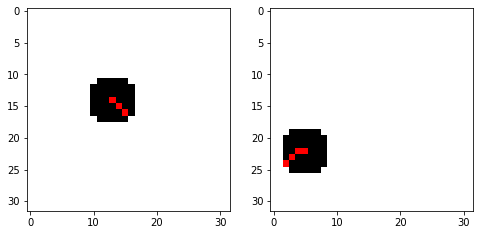

In [6]:
idx = 1
img, img_next = X[idx], X_next[idx]

fig = plt.figure(figsize=(8,8))

fig.add_subplot(1,2,1)
plt.imshow(img.transpose(1,2,0))

fig.add_subplot(1,2,2)
plt.imshow(img_next.transpose(1,2,0))

### Construct encoder/decoder

In [7]:
dim_in = X[0].shape
dim_z = 6
dim_u = 0

In [8]:
model = E2C(dim_in, dim_z, dim_u, config='ball')
inp = torch.from_numpy(X[:2]).float()

mean, logvar = model.encode(inp)

In [9]:
model.decode(mean).shape

torch.Size([2, 3, 32, 32])

## Training loop

In [10]:
before = torch.from_numpy(X[:2]).float()
after = torch.from_numpy(X_next[:2]).float()
ctrl = torch.empty(NUM_DATA, dim_u)

model.forward(before, ctrl, after);

In [20]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# training parameters
TRAINING_ITERATIONS = int(100000)
BATCH_SIZE = int(2)
CHECKPOINT_AFTER = int(2500)
SAVEPOINT_AFTER = int(20000)
TEST_BATCH_SIZE = int(2)

rand_idx = list(np.arange(0, X_next.shape[0]-1))
indices = [rand_idx[ii * BATCH_SIZE:(ii + 1) * BATCH_SIZE] \
    for ii in range((len(rand_idx) + BATCH_SIZE - 1)     // BATCH_SIZE)]
if len(indices[-1]) == 1:
    # make sure batch doesn't just have one data point
    indices[-1].append(indices[-1][0])

itr = 1
for epoch in range(TRAINING_ITERATIONS):
    for ii, idx in enumerate(indices):
        optimizer.zero_grad()

        before = torch.from_numpy(X[idx]).float()
        ctrl = torch.empty(len(idx), dim_u)
        after = torch.from_numpy(X_next[idx]).float()

        next_pre_rec = model(before, ctrl, after)

        loss_rec, loss_trans = compute_loss(\
            model.x_dec, model.x_next_pred_dec, \
            before, after, \
            model.Qz, model.Qz_next_pred, model.Qz_next, mse=True)

        loss = loss_rec # + loss_trans
        loss.backward()
        optimizer.step()

        if itr % CHECKPOINT_AFTER == 0:
            rand_idx = list(np.arange(0, X.shape[0]))
            random.shuffle(rand_idx)
            test_idx = rand_idx[:TEST_BATCH_SIZE]
            before = torch.from_numpy(X[test_idx]).float()
            ctrl = torch.empty(len(test_idx), dim_u)
            after = torch.from_numpy(X_next[test_idx]).float()
            next_pre_rec = model(before, ctrl, after)
            x_next_reconst_loss = (before - next_pre_rec).pow(2).sum(dim=1).mean().detach().numpy()
            print('Average reconstruction loss: {}'.format(x_next_reconst_loss))

        if itr % SAVEPOINT_AFTER == 0:
            fn_pt_model = "./dump.pt"
#             torch.save(model.state_dict(), fn_pt_model)
#             print("Saved model at {}".format(fn_pt_model))

        itr += 1

#         print('loss_rec:{}, loss_trans:{}'.format(loss_rec.item(), loss_trans.item()))

Average reconstruction loss: 0.3755623698234558
Average reconstruction loss: 0.3601799011230469
Average reconstruction loss: 0.36527857184410095
Average reconstruction loss: 0.36364293098449707
Average reconstruction loss: 0.3790653347969055
Average reconstruction loss: 0.37956729531288147
Average reconstruction loss: 0.3899807333946228
Average reconstruction loss: 0.5519022345542908
Average reconstruction loss: 0.39130645990371704
Average reconstruction loss: 0.4882790744304657
Average reconstruction loss: 0.4696277379989624
Average reconstruction loss: 0.4134254455566406
Average reconstruction loss: 0.5641186237335205
Average reconstruction loss: 0.5207706689834595
Average reconstruction loss: 0.4976283311843872
Average reconstruction loss: 0.6018413305282593
Average reconstruction loss: 0.5708572864532471
Average reconstruction loss: 0.43165597319602966
Average reconstruction loss: 0.4646272361278534
Average reconstruction loss: 0.4633016288280487
Average reconstruction loss: 0.4664

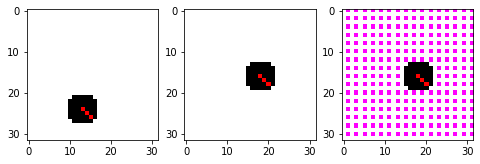

In [74]:
idx = 2
overfit_idx = 0
img_overfit = X[overfit_idx]

# Generate some random dummy image
img_inp = None
while img_inp is None:
    x0 = np.hstack((posbounds[1] * np.random.rand(2), velmax*np.ones(2)))
    img_inp = create_img(x0, posbounds)
X_rand = np.zeros((1,3,W,W))
X_rand[0,:,:,:] = img_inp

before = torch.from_numpy(X_rand).float()
ctrl = torch.empty(before.shape[0], dim_u)
img_reconstruct = model.decode(model.encode(before)[0])[overfit_idx,:,:,:].detach().numpy()
img_reconstruct = np.minimum(img_reconstruct, 1.)  # saturate pixel values to [0,1]
img_reconstruct = np.maximum(img_reconstruct, 0.)

fig = plt.figure(figsize=(8,8))
 
# Input image
fig.add_subplot(1,3,1)
plt.imshow(X_rand[0,:,:,:].transpose(1,2,0))

# "True" image that was overfit to
fig.add_subplot(1,3,2)
plt.imshow(img_overfit.transpose(1,2,0))

fig.add_subplot(1,3,3)
plt.imshow(img_reconstruct.transpose(1,2,0))

In [ ]:
# from IPython import display
# import matplotlib.pyplot as plt

# %matplotlib inline

# import gym
# from gym import wrappers

# env = gym.make('CartPole-v0')
# # env = wrappers.Monitor(env, "./gym-results", force=True)
# env.reset()

# # plt.figure(figsize=(9,9))
# # img = plt.imshow(env.render(mode='rgb_array')) # only call this once

# for _ in range(10):
# #     img.set_data(env.render(mode='rgb_array')) # just update the data
# #     display.display(plt.gcf())
# #     display.clear_output(wait=True)

#     obs, reward, done, info = env.step(env.action_space.sample())
# #     env.render()
#     if done:
#         env.reset()

# env.close()